#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [6]:
from math import exp, log, copysign # вспомогательные импорты и функции
from typing import List, Tuple

def dot(a, b):
    return sum(x*y for x, y in zip(a, b))

def sign(x):
    return [copysign(1, v) if v != 0 else 0 for v in x]

In [7]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float: # вычисляем лос по формуле выше
    N = len(X)
    total_val = 0.0
    for i in range(N):
        wx = dot(w, X[i]) + w0
        total_val += log(1 + exp(-y[i] * wx))
    loss_ans = total_val / N
    loss_ans += gamma * sum(abs(x) for x in w)
    loss_ans += beta * sum(x**2 for x in w) / 2
    return loss_ans

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [4]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    N = len(X) # N - число объектов
    D = len(w) # D - число признаков
    grad_w = [0.0 for _ in range(D)] # инициализируем градиенты нулями
    grad_w0 = 0.0

    for i in range(N):
        xi = X[i]
        yi = y[i] # метка i-го объекта
        wx = dot(w, xi) + w0 # это скалярное произведение w и xi плюс смещение
        exp_term = exp(yi * wx)

        coef = -yi / (1.0 + exp_term) # коэффициент для градиента logloss
        for d in range(D):
            grad_w[d] += xi[d] * coef # накапливаем вклад по w
        grad_w0 += coef # накапливаем вклад по w0
    grad_w = [g / N for g in grad_w]
    grad_w0 /= N

    sign_w = sign(w) # вычисляем sign для L1 регуляризации
    for d in range(D):
        grad_w[d] += gamma * sign_w[d] + 2 * beta * w[d] # регуляризуем

    return grad_w, grad_w0


In [5]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print("grad_w:", grad_w)
print("grad_w0:", grad_w0)

assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

grad_w: [np.float64(-2.732621805077044), np.float64(-1.8717639244739401), np.float64(1.300510229531108), np.float64(2.535988157689178), np.float64(-2.7119827821625706)]
grad_w0: -0.20782319347690742


####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve
import random

In [10]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42): # инициализируем параметры
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None # здесь будут веса модели
        self.w0 = None
        self.loss_vector = [] # это что бы потом график нарисовать по значениям лосса на итерациях

    def fit(self, X, y):
        random.seed(self.random_state) # задаем сид
        N = len(X)
        D = len(X[0])
        self.w0 = 0.0
        self.w = [random.uniform(-0.01, 0.01) for _ in range(D)] # инициализация весов случайными значениями
        prev_w = self.w[:] # скопировали веса
        prev_w0 = self.w0

        for it in range(self.max_iter): # основное обучение
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta) # считаем градиенты по всем весам

            self.w = [wi - self.lr * gwi for wi, gwi in zip(self.w, grad_w)] # w = w - lr * grad_w
            self.w0 = self.w0 - self.lr * grad_w0 # обновляем bias

            temp = sum((wi - pwi) ** 2 for wi, pwi in zip(self.w, prev_w)) + (self.w0 - prev_w0) ** 2 # смотрим насколько веса изменились

            if temp < self.tolerance: # если изменение очень маленькое выходим из цикла
                break

            prev_w = self.w[:] # снова копируем веса
            prev_w0 = self.w0
            self.loss_vector.append(loss(X, y, self.w, self.w0, self.gamma, self.beta)) # сохраняем лосс на конкретной итерации
        return self

    def predict(self, X):
        return [1 if (dot(self.w, xi) + self.w0) >= 0 else -1 for xi in X] # если результат >= 0 то это класс +1

In [11]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [12]:
def plot_decision_boundary(model, X, y):
    X = np.array(X) # преобразуем в массив numpy что бы было удобнее работать
    y = np.array(y)

    plt.figure(figsize=(5,5))
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', label='+1')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c='g', label='-1')

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # определяем диапазон значений
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # определяем диапазон значений

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))

    grid = np.c_[xx.ravel(), yy.ravel()] # создаем пары координат
    predicted = model.predict(grid) # предсказания класса

    predicted = np.array(predicted).reshape(xx.shape)

    plt.contour(xx, yy, predicted, levels=[0], linewidths=2, colors='black') # линия которая отделяет классы
    plt.legend() # выводим метки классов
    plt.tight_layout() # выравнивание элементов
    plt.show()

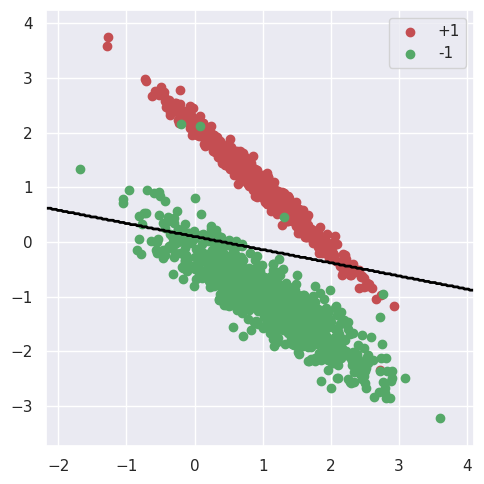

In [13]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [14]:
def plot_loss_history(model):
    plt.figure(figsize=(10,10)) # cоздаём  график 10x10
    plt.plot(model.loss_vector)
    plt.xlabel('Итерация')                         # Подписываем ось X: номер итерации обучения
    plt.title('Значение функции потерь на шаге обучения')
    plt.show()

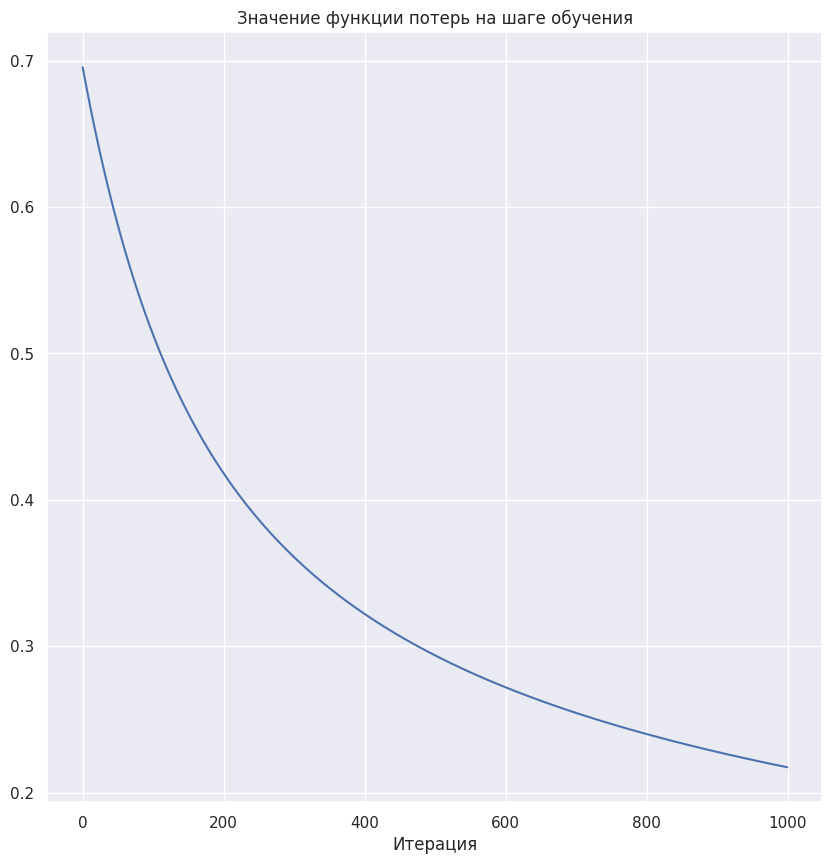

In [15]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
y_binary = ((y + 1) // 2).astype(int) # переводим метки классов в 0 и 1
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.33, random_state=42) # разбиваем на обучающую и тестовую выборки
kernels = ['linear', 'poly', 'rbf'] # список ядер
cs_param = [0.1, 1, 10] # параметры жёсткости регуляризации

for kernel in kernels: # перебираем ядра
    for C in cs_param: # перебираем значения параметра C
        clf = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test) # предсказываем метки классов
        y_score = clf.predict_proba(X_test)[:,1] # получаем вероятности принадлежности к классу 1

        acc = accuracy_score(y_test, y_pred) # считаем метрики
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_score)

        print(f"kernel type={kernel:7} C={C:4} | Acc={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | AUC-ROC={auc:.3f} | F1-Score={f1:.3f}")

kernel type=linear  C= 0.1 | Acc=0.993 | Precision=0.990 | Recall=0.997 | AUC-ROC=0.999 | F1-Score=0.993
kernel type=linear  C=   1 | Acc=0.993 | Precision=0.990 | Recall=0.997 | AUC-ROC=0.999 | F1-Score=0.993
kernel type=linear  C=  10 | Acc=0.993 | Precision=0.990 | Recall=0.997 | AUC-ROC=0.999 | F1-Score=0.993
kernel type=poly    C= 0.1 | Acc=0.995 | Precision=0.993 | Recall=0.997 | AUC-ROC=0.994 | F1-Score=0.995
kernel type=poly    C=   1 | Acc=0.995 | Precision=0.993 | Recall=0.997 | AUC-ROC=0.995 | F1-Score=0.995
kernel type=poly    C=  10 | Acc=0.995 | Precision=0.993 | Recall=0.997 | AUC-ROC=0.995 | F1-Score=0.995
kernel type=rbf     C= 0.1 | Acc=0.995 | Precision=0.993 | Recall=0.997 | AUC-ROC=0.999 | F1-Score=0.995
kernel type=rbf     C=   1 | Acc=0.995 | Precision=0.993 | Recall=0.997 | AUC-ROC=0.999 | F1-Score=0.995
kernel type=rbf     C=  10 | Acc=0.993 | Precision=0.990 | Recall=0.997 | AUC-ROC=0.995 | F1-Score=0.993


#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=1e-2, C=1.0, max_iter=1000, tolerance=1e-6, random_state=42):
        self.C = C # коэффициент регуляризации
        self.lr = lr # cкорость обучения
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        X = np.asarray(X) # преобразуем в numpy массив для удобства
        y = np.asarray(y)
        n_samples, n_features = X.shape # число объектов и признаков

        self.w_ = rng.normal(scale=0.01, size=n_features) # инициализируем веса
        self.b_ = 0

        for it in range(self.max_iter): # цикл обучения
            scores = X @ self.w_ + self.b_ #  скоры модели
            mask = y * scores < 1
            grad_w = -self.C * np.mean((y[mask][:, None] * X[mask]), axis=0) if np.any(mask) else 0 # считаем градиент по w только по ошибающимся объектам
            grad_b = -self.C * np.mean(y[mask]) if np.any(mask) else 0 # градиент по смещению
            grad_w += self.w_ # производнуая от регуляризации L2

            new_n = np.linalg.norm(self.lr*grad_w) + np.abs(self.lr*grad_b) # норма величины шага обновления по w и b
            if new_n < self.tolerance:
                break # если шаг меньше порога, то выходим

            self.w_ -= self.lr * grad_w # обновление весов
            self.b_ -= self.lr * grad_b
        return self

    def decision_function(self, X):
        return X @ self.w_ + self.b_ # считаем значение гиперплоскости без функций активации

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0, 1, -1) # +1, если находимся по одну сторону от разделяющей гиперплоскости, -1 иначе

    def predict_proba(self, X):
        from scipy.special import expit
        s = self.decision_function(X)
        return np.column_stack([1-expit(s), expit(s)]) # отдаем вероятности классов

In [19]:
from sklearn.model_selection import train_test_split

y_input = np.where(np.asarray(y) <= 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_input, test_size=0.3, random_state=42)

clf = HingeLossClassifier(lr=0.01, C=1.0, max_iter=900)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score((y_test > 0).astype(int), y_score)
print(f"Метрики классификатора: Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | AUC-ROC={auc:.3f} | F1-Score={f1:.3f}")


Метрики классификатора: Accuracy=0.965 | Precision=0.969 | Recall=0.958 | AUC-ROC=0.993 | F1-Score=0.964


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [20]:
from collections import Counter

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors # число соседей
        self.metric = metric

    def _euclidean_dist(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2, axis=-1)) # считаем евклидово расстояние между векторами

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.classes_ = np.unique(y) # только уникальные классы
        self.class_indices_ = {c: idx for idx, c in enumerate(self.classes_)} # делаем из классов индексы

    def predict(self, X):
        predicts = []
        X = np.array(X) # преобразуем в numpy массив для удобства
        for x in X:
            dists = self._euclidean_dist(self.X_train, x) # считаем расстояния до всех точек
            nearest_idx = np.argsort(dists)[:self.n_neighbors] # берём n_neighbors ближайших соседей по расстоянию
            neighbor_labels = self.y_train[nearest_idx] # смотрим метки соседей
            counts = Counter(neighbor_labels) # считаем число голосов за каждый класс
            pred = counts.most_common(1)[0][0] # класс с максимальным числом голосов
            predicts.append(pred)
        return np.array(predicts)

    def predict_proba(self, X):
        probas = []
        X = np.array(X) # преобразуем в numpy массив для удобства
        n_classes = len(self.classes_) # число классов
        for x in X:
            dists = self._euclidean_dist(self.X_train, x) # считаем расстояния до всех точек
            nearest_idx = np.argsort(dists)[:self.n_neighbors] # берём n_neighbors ближайших соседей по расстоянию
            neighbor_labels = self.y_train[nearest_idx] # смотрим метки соседей
            probability = np.zeros(n_classes) # инициализируем массив для числа голосов
            for c in neighbor_labels:
                probability[self.class_indices_[c]] += 1
            probability /= self.n_neighbors # считаем долю голосов (это вероятность)
            probas.append(probability)
        return np.array(probas)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNNClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)

class_index = np.where(knn.classes_ == 1)[0][0]
y_score = y_prob[:, class_index]
auc = roc_auc_score(y_test, y_score)

print(f"Метрики KNN: Accuracy={accuracy_score(y_test, y_pred):.3f} | Precision={precision_score(y_test, y_pred, average='weighted'):.3f} | Recall={recall_score(y_test, y_pred, average='weighted'):.3f} | AUC-ROC={auc:.3f} | F1-Score={f1_score(y_test, y_pred, average='weighted'):.3f}")

Метрики KNN: Accuracy=0.994 | Precision=0.994 | Recall=0.994 | AUC-ROC=0.994 | F1-Score=0.994


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
X_train = pd.read_csv("images_train.csv", header=None).values
y_train = pd.read_csv("labels_train.csv", header=None).values.ravel()
X_test = pd.read_csv("images_test.csv", header=None).values
y_test = pd.read_csv("labels_test.csv", header=None).values.ravel()

X_full = np.vstack([X_train, X_test])
y_full = np.hstack([y_train, y_test])

X_tr = X_full[:50000]
y_tr = y_full[:50000]
X_te = X_full[50000:]
y_te = y_full[50000:]

print(f"Train: {X_tr.shape}, Test: {X_te.shape}") # проверим размерности

Train: (50000, 784), Test: (20000, 784)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

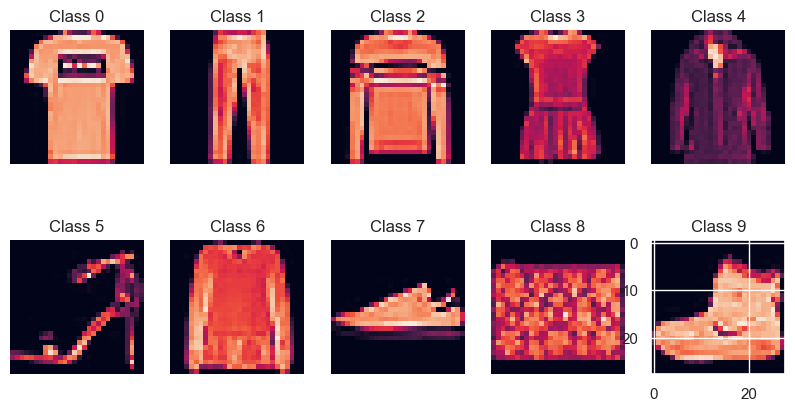

In [ ]:
classes = np.unique(y_tr) # метки классов
plt.figure(figsize=(10, 5))

for idx, cls in enumerate(classes): # перебираем все классы и индексы
    plt.axis('off') # убирам оси
    i = np.where(y_tr == cls)[0][0] # находим индексы элементов класса cls внутри y_tr
    image = X_tr[i].reshape(28, 28) # переводим из вектора в картинку
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f"Class {cls}")
plt.show() # показываем рисунок

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
scaler_std = StandardScaler()
X_tr_std = scaler_std.fit_transform(X_tr)
X_te_std = scaler_std.transform(X_te)

scaler_mm = MinMaxScaler()
X_tr_mm = scaler_mm.fit_transform(X_tr)
X_te_mm = scaler_mm.transform(X_te)

print("Стандартный: X_tr_std mean {:.2f}, std {:.2f}".format(X_tr_std.mean(), X_tr_std.std()))
print("MinMax: X_tr_mm min {:.2f}, max {:.2f}".format(X_tr_mm.min(), X_tr_mm.max()))

Стандартный: X_tr_std mean -0.00, std 1.00
MinMax: X_tr_mm min 0.00, max 1.00


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings

In [ ]:
def grid_gen(X, y):
    for params in params_grid2:
        logreg = LogisticRegression(**params, n_jobs=-1 if params['solver']=='saga' else 1)
        yield logreg, params

warnings.filterwarnings('ignore') # отключаем предупреждения чтобы не мешали
# список гиперпараметров для перебора в knn
params_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'],'p': [1, 2]}  # метрика 1 — манхэттен, 2 — евклидова

print("перебираем Knn:\n")
knn = KNeighborsClassifier(n_jobs=-1)
# настраиваем GridSearchCV для перебора параметров на кросс-валидации 5 фолдов n_jobs=-1 — параллелим
gcv_knn = GridSearchCV(knn, params_knn, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
gcv_knn.fit(X_tr_std, y_tr)

print("KNN лучшая комбинация:", gcv_knn.best_params_)
print("KNN лучшая точность: {:.4f}".format(gcv_knn.best_score_))

knn_acc = accuracy_score(y_te, gcv_knn.best_estimator_.predict(X_te_std))
print("KNN точность на тестовой выборке: {:.4f}".format(knn_acc))

param_grid_logreg = { # это уже для логрега
    "solver": ["lbfgs", "saga"], # перебираем солверы
    "penalty": ["l2"],
    "C": [0.1, 0.01, 1, 10], # перебираем интенсивность регуляризации
    "max_iter": [125],
    "multi_class": ["multinomial"]
}


перебираем Knn:

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=16.5min
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=16.5min
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=16.5min
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=16.5min
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=16.5min
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=16.5min
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=16.5min
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=16.5min
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=16.5min
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=16.5min
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time= 4.4min
[CV] END ................n_neig

In [ ]:
logreg = LogisticRegression()
params_grid2 = [] # список для наборов параметров
for params in ParameterGrid(param_grid_logreg):
    params_grid2.append(params)

best_acc = 0 # лучшая точность
best_model = None # лучший классификатор
best_params = None # лучшие параметры


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # кросс-валидация с перемешиванием
print("\n перебираем LogisticRegression:")
for clf, params in grid_gen(X_tr_std, y_tr):
    accs = []
    for trainIdx, valid in cv.split(X_tr_std, y_tr):
        clf.fit(X_tr_std[trainIdx], y_tr[trainIdx])
        predicts = clf.predict(X_tr_std[valid]) # предсказываем на валидации
        accs.append(accuracy_score(y_tr[valid], predicts)) # cчитаем accuracy
    avg_acc = np.mean(accs)
    # среднее accuracy
    print("params:", params, "cv acc:{:.4f}".format(avg_acc))
    if avg_acc > best_acc:
        best_acc = avg_acc
        best_model = clf
        best_params = params

print("LogisticRegression лучшая комбинация:", best_params)
print("LogisticRegression лучшая точность: {:.4f}".format(best_acc))
print("LogisticRegression точность на тестовой выборке: {:.4f}".format(accuracy_score(y_te, best_model.predict(X_te_std))))


 перебираем LogisticRegression:
params: {'C': 0.1, 'max_iter': 125, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'} cv acc:0.8506
params: {'C': 0.1, 'max_iter': 125, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'} cv acc:0.8562
params: {'C': 0.01, 'max_iter': 125, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'} cv acc:0.8565
params: {'C': 0.01, 'max_iter': 125, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'} cv acc:0.8556
params: {'C': 1, 'max_iter': 125, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'} cv acc:0.8467
params: {'C': 1, 'max_iter': 125, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'} cv acc:0.8562
params: {'C': 10, 'max_iter': 125, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'} cv acc:0.8466
params: {'C': 10, 'max_iter': 125, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'} cv acc:0.8562
LogisticRegression лучшая комбинация: {'C': 0.0

### Результаты валидации:
KNN (по n_neighbors, weights, p): best_cv = 0.8609
LogisticRegression (по solver, C, max_iter, multi_class, penalty=l2): best_cv = 0.8565
### Результаты теста:
KNN: 0.8588 (best params: n_neighbors=5, p=1, weights=distance)
LogisticRegression: 0.8477 (best params: C=0.01, solver=lbfgs, penalty=l2, multi_class=multinomial, max_iter=125)

## Вывод и сравнение
KNN показывает лучшее качество на кросс-валидации на тесте
Обобщение у KNN хуже, разница между CV и тестом минимальна (0.8609 к 0.8588), у логистической регрессии падение больше (0.8565 к 0.8477).
### Возможные причины:
Нелинейная граница решений. KNN — локальный, нелинейный метод, он лучше «подхватывает» локальные структуры данных, тогда как LogisticRegression — линейная модель.
Лучшие параметры KNN — p=1 (манхэттенская метрика) и weights=distance. В стандартизированных и умеренно высокомерных пространствах L1-метрика зачастую устойчивее к «проклятию размерности», а взвешивание по расстоянию снижает влияние дальних (шумных) соседей.
Для LogisticRegression лучшим стал сильный L2-регуляризатор (C=0.01), что намекает на склонность данных к переобучению без регуляризации. Сильная регуляция с линейной моделью могла недоучить сложные нелинейности.
Почему подбирались именно эти гиперпараметры

## KNN:
n_neighbors - главный регулятор баланса пере/недообучения
weights - влияет на устойчивость к шуму
p ∈ {1, 2} — метрика расстояния (манхэттенская/евклидова) определяет сложность модели и характер аппроксимации
## LogisticRegression:
C — сила L2-регуляризации
solver ∈ {lbfgs, saga} — разные алгоритмы оптимизации
penalty=l2, multi_class=multinomial — корректная многоклассовая постановка с хорошо работающим L2
max_iter — влияет и на способность модели обобщать, и на сходимость/стабильность обучения.

### Что можно улучшить
Для LogisticRegression можно расширить сетку за счет penalty ∈ {l1, elasticnet} и добавить l1_ratio для saga
Для KNN можно добрать попробовать большее окно соседей и другие p
LogisticRegression лучше, если важна скорость, KNN дольше работает на предсказании

### Итог
В данном эксперименте KNN лучше работает по accuracy на тесте (0.8588 против 0.8477 у LogisticRegression). Возможно, данные имеют нелинейные зависимости, которые KNN понимает лучше, а логистическая регрессия с L2 — линейна недоучивает эти особенности

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.